In [ ]:
from google.colab import drive
drive.mount('/content/drive')
 
%cd drive/MyDrive/RecommendationModel/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/RecommendationModel


## Imports










In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

## Data

In [ ]:
ratings = pd.read_csv('data/rating.csv')
movies = pd.read_csv('data/movies.csv')
urls = pd.read_csv('data/movies_url.csv')
movies_with_links = pd.read_csv('data/movies_with_links.csv')
movies_info = pd.read_csv('data/movies_complete.csv')

# Data Synchronisation

In [ ]:
ratings = pd.merge(ratings, movies, on='movieId')
ratings['title'] = ratings['title'].astype('string')
ratings.loc[ratings['title']=='War of the Worlds (2005)', 'movieId']=34048
ratings.loc[ratings['title']=='Saturn 3 (1980)', 'movieId']=2851
ratings.loc[ratings['title']=='Eros (2004)', 'movieId']=32600
ratings.loc[ratings['title']=='Emma (1996)', 'movieId']=838
ratings.loc[ratings['title']=='Confessions of a Dangerous Mind (2002)', 'movieId']=6003

In [ ]:
g = ratings.groupby('userId')['rating'].count()
top_users = g.sort_values(ascending=False)[:15]
g = ratings.groupby('movieId')['rating'].count()
top_movies = g.sort_values(ascending=False)[:15]
top_r = ratings.join(top_users, rsuffix='_r', how='inner', on='userId')
top_r = top_r.join(top_movies, rsuffix='_r', how='inner', on='movieId')
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,1,50,110,260,296,318,356,480,527,589,593,1196,2571,2858,2959
userId,,,,,,,,,,,,,,,
68,2.5,3.0,2.5,5.0,2.0,3.0,3.5,3.5,4.0,3.5,3.5,5.0,4.5,5.0,2.5
182,4.0,4.5,3.5,3.5,5.0,4.5,5.0,3.5,4.0,2.0,4.5,3.0,5.0,5.0,5.0
249,4.0,4.0,5.0,5.0,4.0,4.5,4.5,4.0,4.5,4.0,4.0,5.0,5.0,4.5,5.0
274,4.0,4.0,4.5,3.0,5.0,4.5,4.5,3.5,4.0,4.5,4.0,4.5,4.0,5.0,5.0
288,4.5,NaN,5.0,5.0,5.0,5.0,5.0,2.0,5.0,4.0,5.0,4.5,3.0,NaN,3.5
307,4.0,4.5,3.5,3.5,4.5,4.5,4.0,3.5,4.5,2.5,4.5,3.0,3.5,4.0,4.0
380,5.0,4.0,4.0,5.0,5.0,3.0,5.0,5.0,NaN,5.0,5.0,5.0,4.5,NaN,4.0
387,NaN,4.5,3.5,4.5,5.0,3.5,4.0,3.0,NaN,3.5,4.0,4.5,4.0,4.5,4.5
414,4.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,5.0,5.0


In [ ]:
user_enc = LabelEncoder()
ratings['user'] = user_enc.fit_transform(ratings['userId'].values)
n_users = ratings['user'].nunique()
item_enc = LabelEncoder()
ratings['movie'] = item_enc.fit_transform(ratings['movieId'].values)
n_movies = ratings['movie'].nunique()
ratings['rating'] = ratings['rating'].values.astype(np.float32)
min_rating = min(ratings['rating'])
max_rating = max(ratings['rating'])
n_users, n_movies, min_rating, max_rating

(610, 9724, 0.5, 5.0)

## Test and Train Set

In [ ]:
X = ratings[['user', 'movie']].values
y = ratings['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
n_factors = 50
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

## Training

In [ ]:
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.regularizers import l2
def get_recommendations(n_users, n_movies, n_factors):
    user = Input(shape=(1,))
    u = Embedding(n_users, 
                  n_factors,
                  embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(user)
    u = Reshape((n_factors,))(u)
    
    movie = Input(shape=(1,))
    m = Embedding(n_movies, 
                  n_factors,
                  embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(movie)
    m = Reshape((n_factors,))(m)
    
    x = Dot(axes=1)([u, m])
    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(lr=0.0001)
    model.compile(loss='mean_squared_error', 
                  optimizer=opt, 
                  metrics=['accuracy'])
    return model


In [ ]:
model = get_recommendations(n_users, n_movies, n_factors)
model.summary()

In [ ]:
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=60,
                    verbose=1, validation_data=(X_test_array, y_test))


## Train and Test Loss Curve

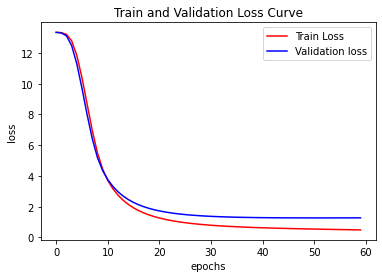

In [ ]:
import matplotlib.pyplot as plt
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss, color='r', label='Train Loss')
plt.plot(val_loss, color='b', label='Validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Train and Validation Loss Curve')
plt.legend()
plt.show()

In [ ]:
model.save('movie_model')

## Predictions

In [ ]:
movie_arr = ratings.movieId.unique()
movie_arr

In [ ]:
user = np.array([100 for i in range(ratings.movieId.nunique())])

In [ ]:
pred = model.predict([user, np.array(range(ratings.movieId.nunique()))])

In [ ]:
pred
pred = pred.reshape(-1) 
pred_ids = (-pred).argsort()[0:10]
pred_ids

In [ ]:
pred_ids = movie_arr[pred_ids]
print(pred_ids)
movies[movies['movieId'].isin(pred_ids)]

[  8574  39183   1246 183911   3949 128097   2568   4732   1476   4174]


,movieId,title,genres
945,1246,Dead Poets Society (1989),Drama
1129,1476,Private Parts (1997),Comedy|Drama
1937,2568,"Mod Squad, The (1999)",Action|Crime
2945,3949,Requiem for a Dream (2000),Drama
3107,4174,Avalon (1990),Drama
3468,4732,Bubble Boy (2001),Comedy
5232,8574,"Claymation Christmas Celebration, A (1987)",Animation|Children|Comedy|Musical
6028,39183,Brokeback Mountain (2005),Drama|Romance
8754,128097,Jim Norton: American Degenerate (2013),Comedy
9684,183911,The Clapper (2018),Comedy


## Data Conversion to JSON

In [ ]:
uratings = ratings.movieId.unique()
uratings = uratings.tolist()

In [ ]:
import json
with open('movieId.json', 'w') as f:
  json.dump(uratings, f)

In [ ]:
ratings_json = ratings[["movieId"]]
ratings_json.to_json(r'web_ratings.json', orient='records')

data = movies_info[["movieId", "title", "genres", "movie_url", "poster", "director"]]
data = data.sort_values('movieId')
data.to_json(r'web_data_complete.json', orient='records')

#Visualizing Embeddings


In [ ]:
model = tf.keras.models.load_model('movie_model/')

In [ ]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 1, 50)        30500       input_11[0][0]                   
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 1, 50)        485950      input_12[0][0]                   
____________________________________________________________________________________________

In [ ]:
embedding_layer = model.get_layer('embedding_11')
embedding_layer = embedding_layer.get_weights()[0]

In [ ]:
embedding_layer.shape

(9719, 50)

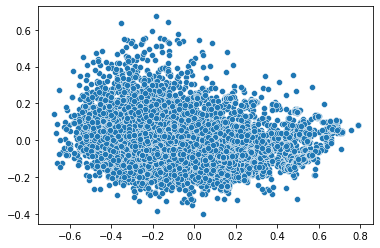

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
pca_result = pca.fit_transform(embedding_layer)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 9719 samples in 0.050s...
[t-SNE] Computed neighbors for 9719 samples in 6.803s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9719
[t-SNE] Computed conditional probabilities for sample 2000 / 9719
[t-SNE] Computed conditional probabilities for sample 3000 / 9719
[t-SNE] Computed conditional probabilities for sample 4000 / 9719
[t-SNE] Computed conditional probabilities for sample 5000 / 9719
[t-SNE] Computed conditional probabilities for sample 6000 / 9719
[t-SNE] Computed conditional probabilities for sample 7000 / 9719
[t-SNE] Computed conditional probabilities for sample 8000 / 9719
[t-SNE] Computed conditional probabilities for sample 9000 / 9719
[t-SNE] Computed conditional probabilities for sample 9719 / 9719
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.077774
[t-SNE] KL divergence after 300 iterations: 2.631267


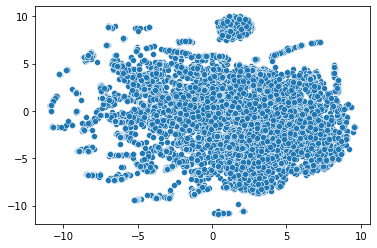

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tnse_results = tsne.fit_transform(embedding_layer)
sns.scatterplot(x=tnse_results[:,0], y=tnse_results[:,1])